# Basic Functions

In [33]:
#Lesson functions
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def hog_cv_init(img_shape, orient=9, pix_per_cell=8, cell_per_block=2):
    global hog_desc
    if hog_desc is None:
        cell_size = (pix_per_cell, pix_per_cell)  # h x w in pixels
        block_size = (cell_per_block, cell_per_block)  # h x w in cells
        nbins = orient # number of orientation bins
        
        hog_desc = cv2.HOGDescriptor(_winSize=(img_shape[1] // cell_size[1] * cell_size[1],
                                          img_shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),_nbins=nbins)   
    return hog_desc

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, pix_per_cell=8, 
                    cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    global hog_desc
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        #Init hog descriptor if None
        if hog_desc is None:
            print("No hog descriptor found!, creating...")
            hog_desc=hog_cv_init(image.shape, orient, pix_per_cell, cell_per_block)
            print("   Done!")
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #Apply hog
        if hog_channel== "ALL":
            hog_features= hog_desc.compute(feature_image)[:,0]
        else:
            hog_features=hog_desc.compute(feature_image[:,:,hog_channel])[:,0]
        # Append the new feature vector to the features list
        """
        print("Spatial features", len(spatial_features))
        print("Histogram features", len(hist_features))
        print("Hog features", len(hog_features))
        """
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

# Important Note:
## If a trained model already exists, skip this section, execute module after the "Load Model section"

# Data import

In [2]:
import glob
import numpy as np

car_files = glob.glob('vehicles\*\*.png')
non_car_files = glob.glob('non-vehicles\*\*.png')
print("Total car images: ", len(car_files))
print("Total Non car images: ", len(non_car_files))
indexes=np.random.randint(len(car_files), size=10)

Total car images:  8792
Total Non car images:  8968


# Color spaces for classification

In [3]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

save_dir=r"./output_images/colorspaces/"
for i in indexes:
    img = cv2.imread(car_files[i])
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_YCR_CB = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCR_CB)
    img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting
    
    plot3d(img_small_RGB, img_small_rgb)
    plt.title("Car RGB")
    file_name= save_dir + 'RGB_Car[' + str(i) +'].jpg'
    plt.savefig(file_name)
    
    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.title("Car HSV")
    file_name= save_dir + 'HSV_Car[' + str(i) +'].jpg'
    plt.savefig(file_name)
    
    plot3d(img_small_YCR_CB, img_small_rgb, axis_labels=list("YRB"))
    plt.title("Car YCR_CB")
    file_name= save_dir + 'YCR_CB_Car[' + str(i) +'].jpg'
    plt.savefig(file_name)
    
    plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
    plt.title("Car YUV")
    file_name= save_dir + 'YUV_Car[' + str(i) +'].jpg'
    plt.savefig(file_name)
    
    plt.close('all')
    
for i in indexes:
    img = cv2.imread(non_car_files[i])
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
    img_small_YCR_CB = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCR_CB)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting
    
    plot3d(img_small_RGB, img_small_rgb)
    plt.title("NonCar RGB")
    file_name= save_dir + 'RGB_NonCar[' + str(i) +'].jpg'
    plt.savefig(file_name)
    
    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.title("NonCar HSV")
    file_name= save_dir + 'HSV_NonCar[' + str(i) +'].jpg'
    plt.savefig(file_name)
    
    plot3d(img_small_YCR_CB, img_small_rgb, axis_labels=list("YRB"))
    plt.title("NonCar YCR_CB")
    file_name= save_dir + 'YCR_CB_NonCar[' + str(i) +'].jpg'
    plt.savefig(file_name)
    
    plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
    plt.title("NonCar YUV")
    file_name= save_dir + 'YUV_NonCar[' + str(i) +'].jpg'
    plt.savefig(file_name)
    
    plt.close('all')
    
    
print("Generated image spaces plots")


Generated image spaces plots


# Model and training

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#Definitions for extracting

color_space='YUV'
size=(32,32)
h_bins=32
hog_orient=7
pix_in_cell=8
cell_in_block=2
hog_channel="ALL"
#Define an empty Hog
hog_desc=None


t=time.time()
print("Extracting features")
car_features=extract_features(car_files, cspace=color_space, spatial_size= size,
                              hist_bins=h_bins, orient=hog_orient, 
                              pix_per_cell=pix_in_cell, cell_per_block=cell_in_block,
                              hog_channel="ALL")
notcar_features=extract_features(non_car_files, cspace=color_space, spatial_size= size,
                              hist_bins=h_bins, orient=hog_orient, 
                              pix_per_cell=pix_in_cell, cell_per_block=cell_in_block,
                              hog_channel="ALL")
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
t2 = time.time()

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
t_time=t2-t
print(round(t_time),"Seconds to preprocess data")

rate=len(X)/(1.*t_time)
print("Extraction Rate: " + str(round(rate)) + " patches/second")
print("Features vector of shape: ", X[0].shape)
print("Using color space ", color_space)
print("Patch Size of ", str(size), " with ",str(h_bins), "histogram bins" )
print("Hog usung channel: ", hog_channel)
print("Along with ", str(hog_orient), "orientations, ", str(pix_in_cell), "pixel per cell and ", str(cell_in_block), "cells per block" )



Extracting features
No hog descriptor found!, creating...
   Done!
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spatial features 3072
Histogram features 96
Hog features 1372
Spa

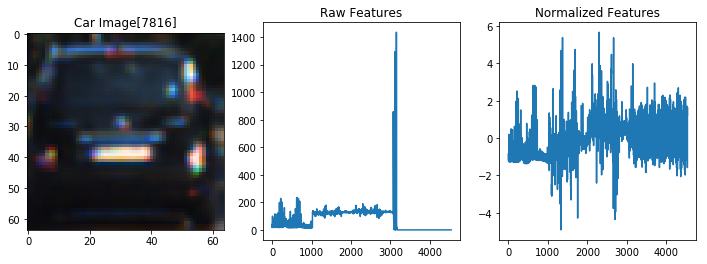

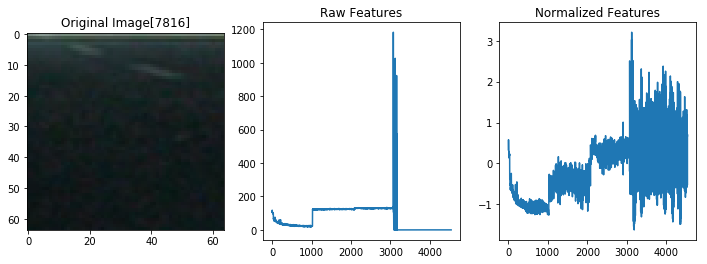

In [5]:
def plot_features(index, cars=True, save_dir=r"./output_images/features_examples/"):
    plt.close('all')
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_files[index]))
    plt.title('Car Image['+str(index)+']')
    plt.subplot(132)
    plt.plot(X[index])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[index])
    plt.title('Normalized Features')
    #fig.tight_layout()
    file_name= save_dir + 'Features[' + str(index) +'].jpg'
    plt.savefig(file_name)
    
    fig1 = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(non_car_files[index]))
    plt.title('Original Image['+str(index)+']')
    plt.subplot(132)
    plt.plot(X[index+len(car_files)])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[index+len(car_files)])
    plt.title('Normalized Features')
    #fig.tight_layout()
    file_name= save_dir + 'Features nonCar[' + str(index) +'].jpg'
    plt.savefig(file_name)
    
for index in indexes:
    plot_features(index)

plt.show()

In [6]:

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc=LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 200
svc.predict(X_test[0:n_predict])
t2 = time.time()
print('My SVC predicts: ', svc.predict(X_test[0:15]))
print('For these 15 labels: ', y_test[0:15])
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
del X
del scaled_X


17.83 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
For these 15 labels:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
0.00301 Seconds to predict 200 labels with SVC


In [7]:
import pickle
model_pickle={"model": svc,
              "Color space": color_space,
              "Patch size": size,
              "Histogram Bins": h_bins,
              "Hog channel": hog_channel,
              "Hog Orientation": hog_orient,
              "Pixels per cell": pix_in_cell,
              "Cells per Block": cell_in_block,
             }
pickle.dump(model_pickle, open ('model/model.p', "wb"))
print("Pickled Model saved")

Pickled Model saved


In [8]:
#http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

# Import Model

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import pickle

pickled_model=pickle.load(open("model/model.p","rb"))

svc= pickled_model["model"]
color_space=pickled_model["Color space"]
size=pickled_model["Patch size"]
h_bins=pickled_model["Histogram Bins"]
hog_channel=pickled_model["Hog channel"]
hog_orient=pickled_model["Hog Orientation"]
pix_in_cell=pickled_model["Pixels per cell"]
cell_in_block=pickled_model["Cells per Block"]

hog_desc=None
print("Imports done!")




Imports done!


In [167]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img_shape, x_start_stop=[None, None], y_start_stop=None,
                    xy_window=None, xy_overlap=(0.5, 0.5)):
    if xy_window is None:
        xy_window = (32, 32)
    if y_start_stop is None:
        y_start_stop = [None, None]
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def get_windows(img, split=False):
    small_winds=slide_window(img.shape, x_start_stop=(480,864), y_start_stop=(384,480),xy_window=(32,32), xy_overlap=(0.10,0))
    med_winds=slide_window(img.shape, x_start_stop=(448,960), y_start_stop=(370,530),xy_window=(64,64), xy_overlap=(.5,.5))
    big_winds=slide_window(img.shape, x_start_stop=(256,1280), y_start_stop=(340,596),xy_window=(128,128), xy_overlap=(0.5,.5))
    """
    print("Small windows: ", len(small_winds))
    print("Medium windows: ", len(med_winds))
    print("Big windows: ", len(big_winds))
    """
    #total_windows=np.vstack((small_winds, med_winds, big_winds))
    total_windows=(small+med+big)
    if split:
        return small_winds, med_winds, big_winds
    return total_windows

def draw_windows(img, windows, color=(255,0,0)):
    for window in windows:
        cv2.rectangle(img, window[0], window[1], color, 2)
    return img

# Malisiewicz et al., 
# http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

def find_cars(img, windows, cspace=color_space, spatial_size=size,
              hist_bins=h_bins, orient=hog_orient,
              pix_per_cell= pix_in_cell, cell_per_block= cell_in_block,
              hog_channel=hog_channel, model= svc):
              #ystart, ystop, scale, svc, X_scaler, hog_channel, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    features=[]
    #img = img.astype(np.float32)/255
    #Init hog descriptor if None
    if hog_desc is None:
        global hog_desc
        print("No hog descriptor found!, creating...")
        hog_desc=hog_cv_init(image.shape, orient, pix_per_cell, cell_per_block)
        print("   Done!")
    else:
        print("Using previous HOG descriptor")
    
    draw_img = np.copy(img)
    detected=np.zeros(len(windows))
    #print("Total windows", len(detected))
    #print(detected)
    patches=[]
    for window in windows:
        #Window sample: ((768, 468), (896, 596))
        image=img[window[0][1]:window[1][1],window[0][0]:window[1][0],:]
        patches.append(image)
        #if image.shape != spatial_size:
        if image.shape != (64,64):
            #print("Original image_shape: ", image.shape)
            #image = cv2.resize(image, (spatial_size[0],spatial_size[1])) 
            image = cv2.resize(image, (64,64)) 
        #print("Using image shape: ",image.shape)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGBHLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #Apply hog
        if hog_channel== "ALL":
            hog_features= hog_desc.compute(feature_image)[:,0]
        else:
            hog_features=hog_desc.compute(feature_image[:,:,hog_channel])[:,0]
        # Append the new feature vector to the features list
        """
        print("Spatial features", len(spatial_features))
        print("Histogram features", len(hist_features))
        print("Hog features", len(hog_features))
        """
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    eval=svc.predict(features)
    detected=np.nonzero(eval)
    # Return list of feature vectors
    return features, detected
    

<ipython-input-167-12ecb9cf6c17>:135: SyntaxWarning: name 'hog_desc' is used prior to global declaration
  global hog_desc


In [155]:
img_files = glob.glob('test_images/*.jpg')
save_dir= r"output_images/"
copy=np.copy(img)
img=mpimg.imread(img_files[0])
small, med, big=get_windows(img, split=True)
small, med, big=get_windows(img, split=True)
plt.imshow(draw_windows(img, small))
#plt.show()
plt.title("Further windows")

plt.savefig(save_dir+"Long_distance.jpg")
plt.imshow(draw_windows(img, med, color=(0,255,0)))
plt.title("Nearer windows")
plt.savefig(save_dir+"Medium_distance.jpg")
plt.imshow(draw_windows(img, big, color=(0,0,255)))
plt.title("Neighbor windows")
plt.savefig(save_dir+"Short_distance.jpg")

print("Window boundaries images saved!")




Window boundaries images saved!


Using previous HOG descriptor
Found_boxes:  12
After supressing boxes:  (5, 2, 2)
((1152, 404), (1280, 532))
((256, 404), (384, 532))
((864, 434), (928, 498))
((832, 340), (960, 468))
((564, 416), (596, 448))
Total time on execution:  0.1313495635986328


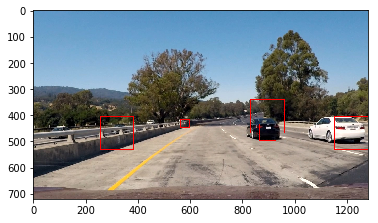

In [200]:
original_image=mpimg.imread(img_files[0])
t=time.time()

spots=get_windows(original_image)
#small, med, big=get_windows(original_image, split=True)

windows=get_windows(original_image)
features, detected= find_cars(original_image, spots)


hits=[]
for i in detected[0]:
    hits.append(spots[i])

    

#result=draw_windows(original_image,hits)
#plt.imshow(result)
#cv2.imwrite(save_dir+"test.jpg", result)
#plt.show()
print("Found_boxes: ", len(hits))

new_boxes=non_max_suppression_fast(np.asarray(hits).reshape(-1,4) ,overlapThresh=0.15)
new_boxes=new_boxes.reshape(-1,2,2)
print("After supressing boxes: ", new_boxes.shape)
#Convert here to list, then tupple

new_boxes=totuple(new_boxes)
for i in new_boxes:
    print(i)
    
supressed=draw_windows(original_image,new_boxes)
t2=time.time()

print("Total time on execution: ",str(t2-t))

plt.imshow(supressed)
cv2.imwrite(save_dir+"test1.jpg", supressed)
plt.show()

## 


In [63]:
check=hits[0]
print(type(check))
print(check[0], check[1])

<class 'numpy.ndarray'>
[536 384] [568 416]
